In [1]:
!pip install opencv-python numpy matplotlib scikit-learn

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 12.3 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 15.4 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 15.3 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [matplotlib]1 [matplotlib]n]


In [38]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time


Processing dataset in: data_check
different_1: ORB_BF_UNMATCHED (10 good matches)
Saved match image at: results/different_1_orb_bf_unmatched.png
different_10: ORB_BF_UNMATCHED (5 good matches)
Saved match image at: results/different_10_orb_bf_unmatched.png
different_2: ORB_BF_UNMATCHED (2 good matches)
Saved match image at: results/different_2_orb_bf_unmatched.png
different_3: ORB_BF_UNMATCHED (5 good matches)
Saved match image at: results/different_3_orb_bf_unmatched.png
different_4: ORB_BF_UNMATCHED (8 good matches)
Saved match image at: results/different_4_orb_bf_unmatched.png
different_5: ORB_BF_UNMATCHED (4 good matches)
Saved match image at: results/different_5_orb_bf_unmatched.png
different_6: ORB_BF_UNMATCHED (6 good matches)
Saved match image at: results/different_6_orb_bf_unmatched.png
different_7: ORB_BF_UNMATCHED (8 good matches)
Saved match image at: results/different_7_orb_bf_unmatched.png
different_8: ORB_BF_UNMATCHED (6 good matches)
Saved match image at: results/differ

<Figure size 600x500 with 0 Axes>

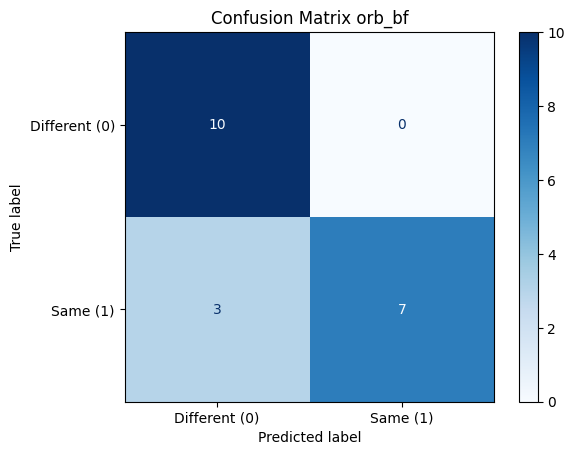

Time taken for ORB + BF matching: 0.26 seconds


In [41]:
def preprocess_fingerprint(image_path):
    img = cv2.imread(image_path, 0)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img_bin
 
def match_fingerprints(img1_path, img2_path):
    img1 = preprocess_fingerprint(img1_path)
    img2 = preprocess_fingerprint(img2_path)
 
    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=1000)
 
    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0, None  # Return 0 matches if no descriptors found
 
    # Use Brute-Force Matcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
 
    # KNN Match
    matches = bf.knnMatch(des1, des2, k=2)
 
    # Apply Lowe's ratio test (keep only good matches)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
 
    # Draw only good matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return len(good_matches), match_img
 
def process_dataset(dataset_path, results_folder):
    threshold = 20  # Adjust this based on tests
    y_true = []  # True labels (1 for same, 0 for different)
    y_pred = []  # Predicted labels
 
    # Create results folder if it does not exist
    os.makedirs(results_folder, exist_ok=True)

    print(f"Processing dataset in: {dataset_path}")

    # Loop through all subdirectories
    for folder in sorted(os.listdir(dataset_path)):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a valid directory
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.tif', '.png', '.jpg'))]
            if len(image_files) != 2:
                print(f"Skipping {folder}, expected 2 images but found {len(image_files)}")
                continue  # Skip if the folder doesn't have exactly 2 images
            img1_path = os.path.join(folder_path, image_files[0])
            img2_path = os.path.join(folder_path, image_files[1])
            match_count, match_img = match_fingerprints(img1_path, img2_path)
 
            # Determine the ground truth (expected label)
            actual_match = 1 if "same" in folder.lower() else 0  # 1 for same, 0 for different
            y_true.append(actual_match)
 
            # Decision based on good matches count
            predicted_match = 1 if match_count > threshold else 0
            y_pred.append(predicted_match)
            result = "orb_bf_matched" if predicted_match == 1 else "orb_bf_unmatched"
            print(f"{folder}: {result.upper()} ({match_count} good matches)")
 
            # Save match image in the results folder
            if match_img is not None:
                match_img_filename = f"{folder}_{result}.png"
                match_img_path = os.path.join(results_folder, match_img_filename)
                cv2.imwrite(match_img_path, match_img)
                print(f"Saved match image at: {match_img_path}")
 
    # Compute and display confusion matrix
    labels = ["Different (0)", "Same (1)"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix orb_bf")
    plt.show()
 
# Example usage
dataset_path = r"data_check"
results_folder = r"results"
start_time = time.time()
process_dataset(dataset_path, results_folder)
end_time = time.time()
print(f"Time taken for ORB + BF matching: {end_time - start_time:.2f} seconds")

different_1: SIFT_FLANN_UNMATCHED (9 good matches)
Saved match image at: results2/different_1_sift_flann_unmatched.png
different_10: SIFT_FLANN_UNMATCHED (5 good matches)
Saved match image at: results2/different_10_sift_flann_unmatched.png
different_2: SIFT_FLANN_UNMATCHED (7 good matches)
Saved match image at: results2/different_2_sift_flann_unmatched.png
different_3: SIFT_FLANN_UNMATCHED (10 good matches)
Saved match image at: results2/different_3_sift_flann_unmatched.png
different_4: SIFT_FLANN_UNMATCHED (15 good matches)
Saved match image at: results2/different_4_sift_flann_unmatched.png
different_5: SIFT_FLANN_UNMATCHED (7 good matches)
Saved match image at: results2/different_5_sift_flann_unmatched.png
different_6: SIFT_FLANN_UNMATCHED (9 good matches)
Saved match image at: results2/different_6_sift_flann_unmatched.png
different_7: SIFT_FLANN_UNMATCHED (7 good matches)
Saved match image at: results2/different_7_sift_flann_unmatched.png
different_8: SIFT_FLANN_UNMATCHED (5 good ma

<Figure size 600x500 with 0 Axes>

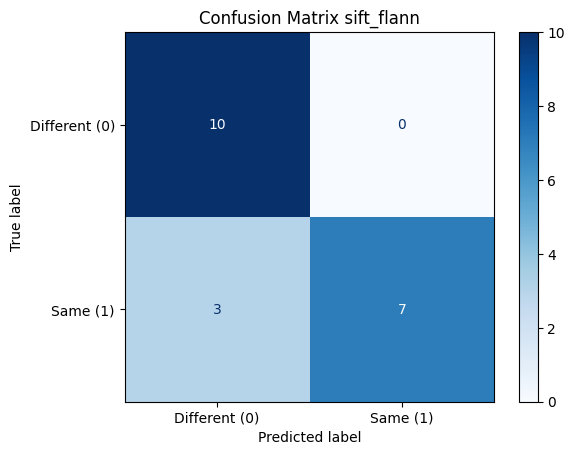

Time taken for SIFT + FLANN matching: 0.68 seconds


In [40]:
def preprocess_fingerprint(image_path):
    img = cv2.imread(image_path, 0)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img_bin
 
def match_fingerprints(img1_path, img2_path):
    img1 = preprocess_fingerprint(img1_path)
    img2 = preprocess_fingerprint(img2_path)
 
    # Initialize SIFT detector
    sift = cv2.SIFT_create(nfeatures=1000)
 
    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0, None  # Return 0 matches if no descriptors found
 
    # FLANN parameters (KD-tree for SIFT)
    index_params = dict(algorithm=1, trees=5)  # KD-tree
    search_params = dict(checks=50)  # Number of checks for nearest neighbors
    flann = cv2.FlannBasedMatcher(index_params, search_params)
 
    # KNN Match
    matches = flann.knnMatch(des1, des2, k=2)
 
    # Apply Lowe's ratio test (keep only good matches)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
 
    # Draw only good matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return len(good_matches), match_img
 
def process_dataset(dataset_path, results_folder):
    threshold = 20  # Adjust this based on tests
    y_true = []  # True labels (1 for same, 0 for different)
    y_pred = []  # Predicted labels
    os.makedirs(results_folder, exist_ok=True)
    for folder in sorted(os.listdir(dataset_path)):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a valid directory
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.tif', '.png', '.jpg'))]
            if len(image_files) != 2:
                print(f"Skipping {folder}, expected 2 images but found {len(image_files)}")
                continue
            img1_path = os.path.join(folder_path, image_files[0])
            img2_path = os.path.join(folder_path, image_files[1])
            match_count, match_img = match_fingerprints(img1_path, img2_path)
 
            # Determine the ground truth
            actual_match = 1 if "same" in folder.lower() else 0  # 1 for same, 0 for different
            y_true.append(actual_match)
 
            # Decision based on good matches count
            predicted_match = 1 if match_count > threshold else 0
            y_pred.append(predicted_match)
            result = "sift_flann_matched" if predicted_match == 1 else "sift_flann_unmatched"
            print(f"{folder}: {result.upper()} ({match_count} good matches)")
            if match_img is not None:
                match_img_filename = f"{folder}_{result}.png"
                match_img_path = os.path.join(results_folder, match_img_filename)
                cv2.imwrite(match_img_path, match_img)
                print(f"Saved match image at: {match_img_path}")
 
    # Compute and display confusion matrix
    labels = ["Different (0)", "Same (1)"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix sift_flann")
    plt.show()
 
# Example usage
dataset_path = r"data_check"
results_folder = r"results2"

start_time = time.time()
process_dataset(dataset_path, results_folder)
end_time = time.time()
print(f"Time taken for SIFT + FLANN matching: {end_time - start_time:.2f} seconds")

In [48]:
def preprocess_fingerprint(image_path):
    img = cv2.imread(image_path, 0)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img_bin
 
def match_fingerprints(img1_path, img2_path):
    img1 = preprocess_fingerprint(img1_path)
    img2 = preprocess_fingerprint(img2_path)
 
    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=1000)
 
    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0, None  # Return 0 matches if no descriptors found
 
    # Use Brute-Force Matcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
 
    # KNN Match
    matches = bf.knnMatch(des1, des2, k=2)
 
    # Apply Lowe's ratio test (keep only good matches)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
 
    # Draw only good matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return len(good_matches), match_img
 
def process_dataset(dataset_path, results_folder):
    threshold = 22  # Adjust this based on tests
    y_true = []  # True labels (1 for same, 0 for different)
    y_pred = []  # Predicted labels
 
    # Create results folder if it does not exist
    os.makedirs(results_folder, exist_ok=True)

    print(f"Processing dataset in: {dataset_path}")

    # Loop through all subdirectories
    for folder in sorted(os.listdir(dataset_path)):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a valid directory
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.tif', '.png', '.jpg'))]
            if len(image_files) != 2:
                print(f"Skipping {folder}, expected 2 images but found {len(image_files)}")
                continue  # Skip if the folder doesn't have exactly 2 images
            img1_path = os.path.join(folder_path, image_files[0])
            img2_path = os.path.join(folder_path, image_files[1])
            match_count, match_img = match_fingerprints(img1_path, img2_path)
 
            # Determine the ground truth (expected label)
            actual_match = 1 if "same" in folder.lower() else 0  # 1 for same, 0 for different
            y_true.append(actual_match)
 
            # Decision based on good matches count
            predicted_match = 1 if match_count > threshold else 0
            y_pred.append(predicted_match)
            result = "orb_bf_matched" if predicted_match == 1 else "orb_bf_unmatched"
            print(f"{folder}: {result.upper()} ({match_count} good matches)")
 
            # Save match image in the results folder
            if match_img is not None:
                match_img_filename = f"{folder}_{result}.png"
                match_img_path = os.path.join(results_folder, match_img_filename)
                cv2.imwrite(match_img_path, match_img)
                print(f"Saved match image at: {match_img_path}")
 


 
# Example usage
dataset_path = r"uia"
results_folder = r"uia1"
start_time = time.time()
process_dataset(dataset_path, results_folder)
end_time = time.time()
print(f"Time taken for ORB + BF matching: {end_time - start_time:.2f} seconds")

Processing dataset in: uia
uia_same: ORB_BF_UNMATCHED (21 good matches)
Saved match image at: uia1/uia_same_orb_bf_unmatched.png
Time taken for ORB + BF matching: 0.07 seconds


In [47]:
def preprocess_fingerprint(image_path):
    img = cv2.imread(image_path, 0)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img_bin
 
def match_fingerprints(img1_path, img2_path):
    img1 = preprocess_fingerprint(img1_path)
    img2 = preprocess_fingerprint(img2_path)
 
    # Initialize SIFT detector
    sift = cv2.SIFT_create(nfeatures=1000)
 
    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0, None  # Return 0 matches if no descriptors found
 
    # FLANN parameters (KD-tree for SIFT)
    index_params = dict(algorithm=1, trees=5)  # KD-tree
    search_params = dict(checks=50)  # Number of checks for nearest neighbors
    flann = cv2.FlannBasedMatcher(index_params, search_params)
 
    # KNN Match
    matches = flann.knnMatch(des1, des2, k=2)
 
    # Apply Lowe's ratio test (keep only good matches)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
 
    # Draw only good matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return len(good_matches), match_img
 
def process_dataset(dataset_path, results_folder):
    threshold = 20  # Adjust this based on tests
    y_true = []  # True labels (1 for same, 0 for different)
    y_pred = []  # Predicted labels
    os.makedirs(results_folder, exist_ok=True)
    for folder in sorted(os.listdir(dataset_path)):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a valid directory
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.tif', '.png', '.jpg'))]
            if len(image_files) != 2:
                print(f"Skipping {folder}, expected 2 images but found {len(image_files)}")
                continue
            img1_path = os.path.join(folder_path, image_files[0])
            img2_path = os.path.join(folder_path, image_files[1])
            match_count, match_img = match_fingerprints(img1_path, img2_path)
 
            # Determine the ground truth
            actual_match = 1 if "same" in folder.lower() else 0  # 1 for same, 0 for different
            y_true.append(actual_match)
 
            # Decision based on good matches count
            predicted_match = 1 if match_count > threshold else 0
            y_pred.append(predicted_match)
            result = "sift_flann_matched" if predicted_match == 1 else "sift_flann_unmatched"
            print(f"{folder}: {result.upper()} ({match_count} good matches)")
            if match_img is not None:
                match_img_filename = f"{folder}_{result}.png"
                match_img_path = os.path.join(results_folder, match_img_filename)
                cv2.imwrite(match_img_path, match_img)
                print(f"Saved match image at: {match_img_path}")

# Example usage
dataset_path = r"uia"
results_folder = r"uia2"
start_time = time.time()
process_dataset(dataset_path, results_folder)
end_time = time.time()
print(f"Time taken for SIFT + FLANN matching: {end_time - start_time:.2f} seconds")

uia_same: SIFT_FLANN_UNMATCHED (15 good matches)
Saved match image at: uia2/uia_same_sift_flann_unmatched.png
Time taken for SIFT + FLANN matching: 0.17 seconds
